In [60]:
import numpy as np
import matplotlib.pyplot as plt 

In [144]:
class system:
    
    def __init__(self
                ,delta_t, t_final, delta_x, x_min, x_max, M
                ,k_0, sigma_0, x_0
                ,L, V_0):
        
        # space & time mesh parameters
        self.delta_t = delta_t
        self.t_final = t_final
        self.delta_x = delta_x
        self.x_min = x_min
        self.x_max = x_max
        self.M = M
        
        # initial wave function parameters
        self.k_0 = k_0
        self.sigma_0 = sigma_0
        self.x_0 = x_0
        
        # potential parameters
        self.L = L
        self.V_0 = V_0
        
        # construct space & time mesh        
        self.x = np.linspace(x_min, x_max, M)
        self.time = np.arange(0,t_final+delta_t, delta_t)
        
        # define vectors for the wave function        
        self.psi_current = np.zeros((M,1), dtype=np.complex)
        self.psi_next = np.zeros((M,1), dtype=np.complex)
        self.psi = np.zeros((M, len(self.time)), dtype=np.complex)
        
        # construct initial state vector        
        self.psi_current = self.psi_0(self.x)
        self.psi[:,0] = self.psi_current
        
        # build L & R matrices
        self.Lmat, self.Rmat = self.build_LR()
    

    def psi_0(self, x):
        return 1/(np.pi*self.sigma_0**2)**(1/4) * np.exp(1j*self.k_0*x) * np.exp(-(x-self.x_0)**2/(2*self.sigma_0**2))
    
    
    def V(self, x):
        return self.V_0 * np.logical_and(0<=x,x<=self.L)

    
    def build_LR(self):
        alpha = self.delta_t / 4 / self.delta_x**2
        beta = 1 + 2j * alpha
        
        L_diag0 = beta + 1j * self.delta_t * self.V(self.x) / 2
        L_diag1 = [-1j*alpha] * (self.M-1)
        
        Lmat = np.diag(L_diag0, 0) + np.diag(L_diag1, 1) + np.diag(L_diag1, -1)
        Rmat = np.conj(Lmat)
        
        return Lmat, Rmat
        
        
    def tridiag_solver(self, matrix, s):
        # solves matrix * x = s for x
        # by using the algorithm in page 5.

        d = np.diag(matrix)
        M = len(d)
        a = matrix[0,1]

        a_prime = np.zeros(M-1, dtype=np.complex)
        a_prime[0] = a/d[0]

        for i in range(1, M-1):
            a_prime[i] = a / (d[i]-a*a_prime[i-1])

        s_prime = np.zeros(M, dtype=np.complex)
        s_prime[0] = s[0]/d[0]

        for i in range(1, M):
            s_prime[i] = (s[i]-a*s_prime[i-1]) / (d[i]-a*a_prime[i-1])

        x = np.zeros(M, dtype=np.complex)
        x[M-1] = s_prime[M-1]

        for i in range(M-2, -1, -1):
            x[i] = s_prime[i] - a_prime[i]*x[i+1]

        return x
        

    def simulation(self):
        for i, t in enumerate(self.time[:-1]):
            self.psi_next = self.tridiag_solver(self.Lmat, self.Rmat.dot(self.psi_current))
            self.psi[:,i+1] = self.psi_next
            self.psi_current = self.psi_next
            
    
    def create_output(self):
        psi = self.psi
        p = np.conj(psi) * psi
        p = np.array(p, dtype=float)
        
        np.savetxt('probability_density_k_0_%g.npy'%(self.k_0), p)
        
        a = np.ones((self.M,1))
        a[0], a[self.M-1] = 0.5, 0.5
        I = p * a
        I = I.sum(axis=0) * self.delta_x
        
        np.savetxt('quality_k_0_%g.npy'%(self.k_0), I)

In [145]:
parameter_values = {'delta_t' : 0.005
                   ,'t_final' : 50
                   ,'delta_x' : 0.05
                   ,'x_min' : -60
                   ,'x_max' : 60
                   ,'M' : 2401 
                   ,'k_0' : 1
                   ,'sigma_0' : 3
                   ,'x_0' : -10
                   ,'L' : 2
                   ,'V_0' : 2}

s = system(**parameter_values)
s.simulation()
s.create_output()

/home/umurcankaya/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:102: ComplexWarning: Casting complex values to real discards the imaginary part


In [153]:
k_0 = 1

p = np.loadtxt('probability_density_k_0_%g.npy'%(k_0))
I = np.loadtxt('quality_k_0_%g.npy'%(k_0))

x = np.linspace(-60, 60, 2401)
t = np.arange(0, 50+0.005, 0.005)

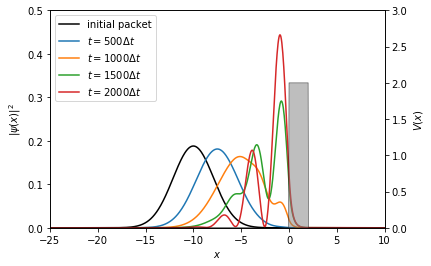

In [196]:
fig, ax = plt.subplots()

ax.plot(x, p[:,0], label='initial packet', c='k')

for i in range(500, 2500, 500):
    ax.plot(x, p[:,i], label='$t=%d\Delta t$'%i)
    
ax.set(xlim=(-25,10), ylim=(0,0.5), xlabel='$x$', ylabel='$|\psi(x)|^2$')
ax.legend(loc='upper left')

bx = ax.twinx()
bx.fill_between(x, s.V(x), edgecolor='k', lw=0.75, facecolor='#7f7f7f', alpha=0.5)
bx.set(ylim=(0,3), ylabel='$V(x)$');

In [230]:
idx = x>2
idx = idx.reshape((len(idx),1))
a = np.ones((len(idx),1))
a[0], a[-1] = 0.5, 0.5
T = p * idx * a
T = T.sum(axis=0) * s.delta_x

T_lim = np.mean(T[-1000:])

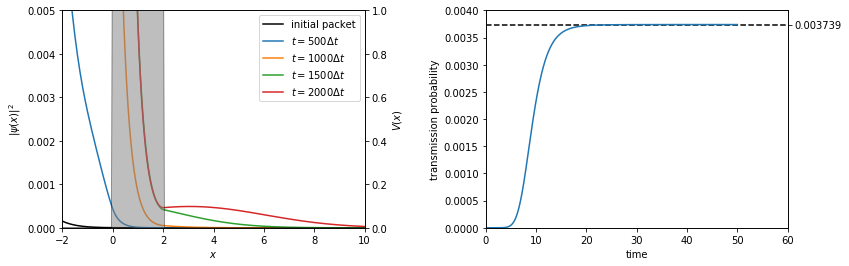

In [238]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))
plt.subplots_adjust(wspace=0.4)

ax[0].plot(x, p[:,0], label='initial packet', c='k')

for i in range(500, 2500, 500):
    ax[0].plot(x, p[:,i], label='$t=%d\Delta t$'%i)
    
ax[0].set(xlim=(-2,10), ylim=(0,5e-3), xlabel='$x$', ylabel='$|\psi(x)|^2$')
ax[0].legend(loc='upper right')

bx0 = ax[0].twinx()
bx0.fill_between(x, s.V(x), edgecolor='k', lw=0.75, facecolor='#7f7f7f', alpha=0.5)
bx0.set(ylim=(0,1), ylabel='$V(x)$');

ax[1].axhline(T_lim, c='k', ls='--')
ax[1].plot(t, T)

ax[1].set(ylim=(0,4e-3), xlim=(0,60), xlabel='time', ylabel='transmission probability')

bx1 = ax[1].twinx()
bx1.set(ylim=ax[1].set_ylim(), yticks=[T_lim]);